**DATA DIRI**

> 
*   Nama   : Arini Ratnasari
*   Email  : ariniratnasari02@gmail.com
*   Alamat : BTN Puskopad Sukajaya Blok C No 26 RT/RW 59/17, Jawa Barat
*   TTL    : Subang, 10 Agustus 2000

**Mengimport Library**

In [1]:
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf

**Mengimport Data**

In [3]:
dataset = pd.read_csv('Sunspots.csv')
dataset.head(10)

,Unnamed: 0,Date,Monthly Mean Total Sunspot Number
0,0,1749-01-31,96.7
1,1,1749-02-28,104.3
2,2,1749-03-31,116.7
3,3,1749-04-30,92.8
4,4,1749-05-31,141.7
5,5,1749-06-30,139.2
6,6,1749-07-31,158.0
7,7,1749-08-31,110.5
8,8,1749-09-30,126.5
9,9,1749-10-31,125.8


**Data Preprocessing**

In [8]:
# Mengecek dimensi dataset
dataset.shape

(3265, 3)

In [6]:
# Mengecek type data dari masing-masing kolom
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3265 entries, 0 to 3264
Data columns (total 3 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Unnamed: 0                         3265 non-null   int64  
 1   Date                               3265 non-null   object 
 2   Monthly Mean Total Sunspot Number  3265 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 76.6+ KB


In [10]:
# Mengecek apakah terdapat missing value
dataset.isnull().sum()

Unnamed: 0                           0
Date                                 0
Monthly Mean Total Sunspot Number    0
dtype: int64

In [13]:
# Hanya menggunakan kolom Monthly Mean Total Sunspot Number
df_new = dataset[['Monthly Mean Total Sunspot Number']]

# Merubah index integer menjadi index waktu
df_new.set_index(dataset['Date'], inplace = True)
df_new.head(10)

,Monthly Mean Total Sunspot Number
Date,
1749-01-31,96.7
1749-02-28,104.3
1749-03-31,116.7
1749-04-30,92.8
1749-05-31,141.7
1749-06-30,139.2
1749-07-31,158.0
1749-08-31,110.5
1749-09-30,126.5


In [14]:
# Mengecek type dataset baru
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3265 entries, 1749-01-31 to 2021-01-31
Data columns (total 1 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Monthly Mean Total Sunspot Number  3265 non-null   float64
dtypes: float64(1)
memory usage: 51.0+ KB


**Visualisasi Data**

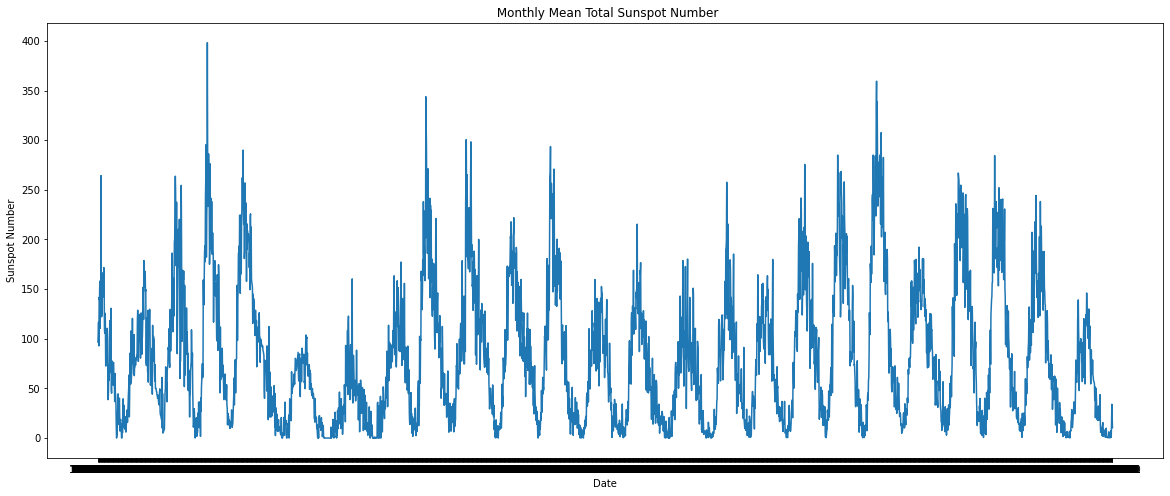

In [15]:
plt.figure(figsize=(20,8))
plt.plot(df_new)
plt.title('Monthly Mean Total Sunspot Number')
plt.xlabel('Date')
plt.ylabel('Sunspot Number')
plt.show()

**Pembentukan Model**

In [16]:
# Mendapatkan nilai dari data
date = dataset['Date'].values
sunspot = dataset['Monthly Mean Total Sunspot Number'].values

In [17]:
# Fungsi di bawah menerima sebuah series/atribut kita yang telah 
# di konversi menjadi tipe numpy, lalu mengembalikan 
# label dan atribut dari dataset dalam bentuk batch.

def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [18]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(sunspot, date, test_size = 0.2, random_state = 0 , shuffle=False)
print(len(x_train), len(x_test))

2612 653


In [19]:
data_train = windowed_dataset(x_train, window_size = 60, 
                              batch_size = 100, shuffle_buffer = 1000)
data_test = windowed_dataset(x_test, window_size = 60, 
                             batch_size = 100, shuffle_buffer = 1000)

model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [20]:
max = dataset['Monthly Mean Total Sunspot Number'].max()
print('Max value : ' )
print(max)

Max value : 
398.2


In [22]:
min = dataset['Monthly Mean Total Sunspot Number'].min()
print('Min Value : ')
print(min)

Min Value : 
0.0


In [23]:
y = (max - min) * (10 / 100)
print(y)

39.82


In [24]:
# Callback
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae')< y):
      self.model.stop_training = True
      print("\nMAE of the model < 10% of data scale")
callbacks = myCallback()

In [25]:
tf.keras.backend.set_floatx('float64')
history = model.fit(data_train, epochs = 500, 
                    validation_data = data_test, callbacks=[callbacks])

Epoch 1/500
26/26 [==============================] - 9s 170ms/step - loss: 108.9303 - mae: 109.4300 - val_loss: 109.0226 - val_mae: 109.5226
Epoch 2/500
26/26 [==============================] - 3s 125ms/step - loss: 105.0367 - mae: 105.5363 - val_loss: 104.7470 - val_mae: 105.2470
Epoch 3/500
26/26 [==============================] - 3s 120ms/step - loss: 100.6541 - mae: 101.1540 - val_loss: 100.3939 - val_mae: 100.8939
Epoch 4/500
26/26 [==============================] - 3s 126ms/step - loss: 96.2545 - mae: 96.7540 - val_loss: 96.0783 - val_mae: 96.5783
Epoch 5/500
26/26 [==============================] - 3s 126ms/step - loss: 91.9229 - mae: 92.4223 - val_loss: 91.8531 - val_mae: 92.3526
Epoch 6/500
26/26 [==============================] - 3s 119ms/step - loss: 87.6782 - mae: 88.1779 - val_loss: 87.7392 - val_mae: 88.2391
Epoch 7/500
26/26 [==============================] - 3s 122ms/step - loss: 83.5724 - mae: 84.0709 - val_loss: 83.7198 - val_mae: 84.2172
Epoch 8/500
26/26 [==========

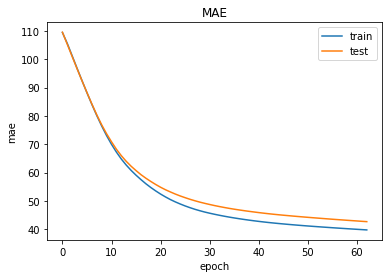

In [26]:
# Plot dari MAE
import matplotlib.pyplot as plt
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('MAE')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

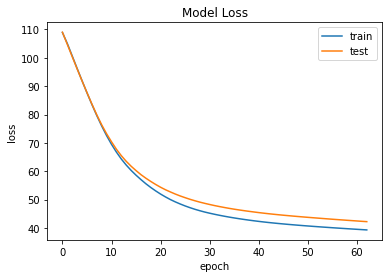

In [27]:
# Plot dari val_loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()